# **TikTok Project**
**Course 6 - The Nuts and bolts of machine learning**

Recall that you are a data professional at TikTok. Your supervisor was impressed with the work you have done and has requested that you build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

A notebook was structured and prepared to help you in this project. A notebook was structured and prepared to help you in this project. Please complete the following questions.

# **Course 6 End-of-course project: Classifying videos using machine learning**

In this activity, you will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

Follow the instructions and answer the questions below to complete the activity. Then, you will complete an Executive Summary using the questions listed on the PACE Strategy Document.

Be sure to complete this activity before moving on. The next course item will provide you with a completed exemplar to compare to your own work.



# **Classify videos using machine learning**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:


1.   **What are you being asked to do? What metric should I use to evaluate success of my business/organizational objective?**

2.   **What are the ethical implications of the model? What are the consequences of your model making errors?**
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?

  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)?

3.   **How would you proceed?**


==> ENTER YOUR RESPONSES HERE

I need to build a binary classification model to predict claim vs opinion status for TikTok videos (`claim_status`). Split the data into a train, validate, and test set, and use that to fit and tune models, before choosing a winner. I'll use recall as the evaluation metric, because I want to minimmize missing videos that violate the terms of service (false negatives). With a false positive, the worst case scenario is that an opinion goes to a human reviewer and wastes that reviewer's time. A false negative allows a video that is a claim to bypass the human reviewer, and might violate the terms of service and allow 'bad' videos to remain up.

**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)


### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

Now load the data from the provided csv file into a dataframe.

**Note:** As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

<img src="images/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**

Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns
data.shape


(19382, 12)

Get the data types of the columns.

In [5]:
# Get data types of columns
data.dtypes


#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Get basic information about the dataset.

In [6]:
# Get basic information
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [7]:
# Generate basic descriptive stats
data.describe(include='all')


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,19084,1.938200e+04,19382.000000,19084,19382,19382,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
unique,NaN,2,NaN,NaN,19012,2,3,NaN,NaN,NaN,NaN,NaN
top,NaN,claim,NaN,NaN,a friend read in the media a claim that badmi...,not verified,active,NaN,NaN,NaN,NaN,NaN
freq,NaN,9608,NaN,NaN,2,18142,15663,NaN,NaN,NaN,NaN,NaN
mean,9691.500000,NaN,5.627454e+09,32.421732,NaN,NaN,NaN,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,NaN,2.536440e+09,16.229967,NaN,NaN,NaN,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,NaN,1.234959e+09,5.000000,NaN,NaN,NaN,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,NaN,3.430417e+09,18.000000,NaN,NaN,NaN,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,NaN,5.618664e+09,32.000000,NaN,NaN,NaN,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,NaN,7.843960e+09,47.000000,NaN,NaN,NaN,504327.000000,125020.000000,18222.000000,1156.250000,292.000000


Check for and handle missing values.

In [8]:
# Check for missing values
data.isna().sum()


#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [9]:
# Drop rows with missing values
data.dropna(inplace=True)
data.isna().sum()


#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

In [10]:

# Display first few rows after handling missing values
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Check for and handle duplicates.

In [11]:
# Check for duplicates
data.duplicated().sum()


0

Check class balance.

In [12]:
# Check class balance
data.claim_status.value_counts()


claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [13]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['transcript_length'] = data.video_transcription_text.str.len()
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcript_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [14]:
# Calculate the average text_length for claims and opinions
data.groupby('claim_status')['transcript_length'].mean()


claim_status
claim      95.376978
opinion    82.722562
Name: transcript_length, dtype: float64

Visualize the distribution of `text_length` for claims and opinions.

c:\Users\johbr\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\johbr\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\johbr\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\johbr\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1075: Fut

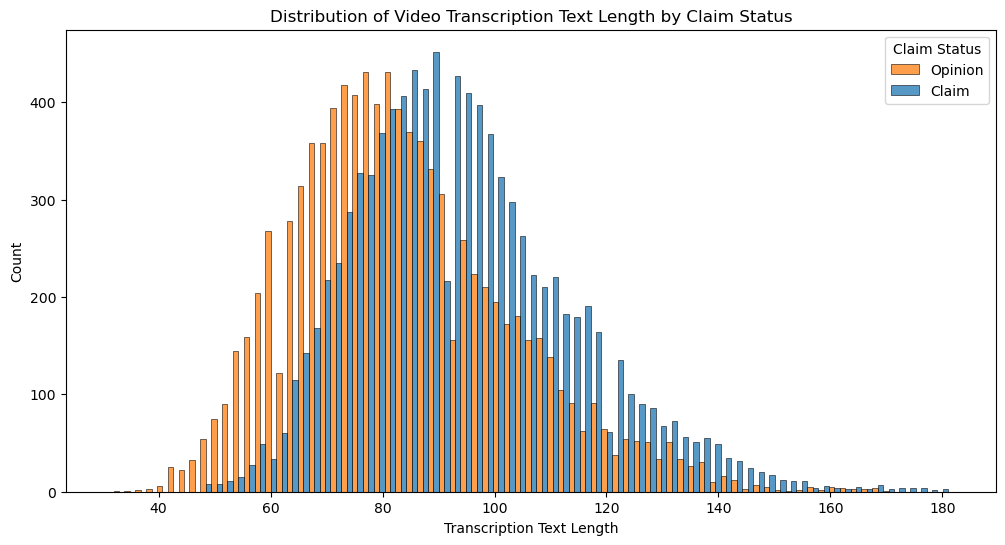

In [15]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
plt.figure(figsize=(12, 6))
sns.histplot(data=data, stat='count', multiple='dodge', x='transcript_length', hue='claim_status', kde=False, legend=True)
plt.title('Distribution of Video Transcription Text Length by Claim Status')
plt.xlabel('Transcription Text Length')
plt.ylabel('Count')
plt.legend(title='Claim Status', labels=['Opinion', 'Claim'])
plt.show()



**Feature selection and transformation**

Encode target and catgorical variables.

In [16]:
# Create a copy of the X data
X = data.copy()

# Drop unnecessary columns
X.drop(columns=['#', 'video_id'], inplace=True)

# Encode target variable
X.claim_status = X.claim_status.map({'opinion': 0, 'claim': 1})

# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first=True)

X.head()


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcript_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4: Split the data**

Assign target variable.

In [17]:
# Isolate target variable
y = X.claim_status


Isolate the features.

In [18]:
# Isolate features
X.drop(columns=['claim_status', 'video_transcription_text'], inplace=True)

# Display first few rows of features dataframe
X.head()


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcript_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [19]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [20]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)  # 0.25 x 0.8 = 0.2


Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [21]:
# Get shape of each training, validation, and testing set
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set target variable shape: {y_train.shape}")
print(f"Validation set target variable shape: {y_val.shape}")
print(f"Testing set target variable shape: {y_test.shape}")


Training set shape: (11450, 10)
Validation set shape: (3817, 10)
Testing set shape: (3817, 10)
Training set target variable shape: (11450,)
Validation set target variable shape: (3817,)
Testing set target variable shape: (3817,)


### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [22]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
param_grid = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }


# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring, refit='recall', cv=5, verbose=1, n_jobs=-1)


In [23]:
%%time
### Fit the model to the data 
rf_cv.fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 3.31 s
Wall time: 2min 35s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [24]:
# Examine best recall score
rf_cv.best_score_


0.9908534395531852

In [25]:
# Examine best parameters
rf_cv.best_params_


{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

Check the precision score to make sure the model isn't labeling everything as claims. You can do this by using the `cv_results_` attribute of the fit `GridSearchCV` object, which returns a numpy array that can be converted to a pandas dataframe. Then, examine the `mean_test_precision` column of this dataframe at the index containing the results from the best model. This index can be accessed by using the `best_index_` attribute of the fit `GridSearchCV` object.

In [26]:
# Access the GridSearch results and convert it to a pandas df
rf_cv_results = pd.DataFrame(rf_cv.cv_results_)

# Examine the GridSearch results df at column `mean_test_precision` in the best index
rf_cv_results['mean_test_precision'][rf_cv.best_index_]


0.9994785483051682

**Question:** How well is your model performing? Consider average recall score and precision score.

Both recall and precision are great. This model is worryingly good at its job.

### **Build an XGBoost model**

In [27]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
param_grid = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scoring, refit='recall', cv=5, verbose=1, n_jobs=-1)


In [28]:
%%time
# Fit the model to the data
xgb_cv.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 20.5 s
Wall time: 36.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [29]:
# Examine best recall score
xgb_cv.best_score_


0.9898176171763818

In [30]:
# Examine best parameters
xgb_cv.best_params_


{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

Repeat the steps used for random forest to examine the precision score of the best model identified in the grid search.

In [31]:
# Access the GridSearch results and convert it to a pandas df
xgb_cv_results = pd.DataFrame(xgb_cv.cv_results_)

# Examine the GridSearch results df at column `mean_test_precision` in the best index
xgb_cv_results['mean_test_precision'][xgb_cv.best_index_]


0.9989540885869099

**Question:** How well does your model perform? Consider recall score and precision score.

This model also does phenomenally well, although slightly less good than the random forest.

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [32]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val)

Display the predictions on the validation set.

In [33]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

Display the true labels of the validation set.

In [34]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

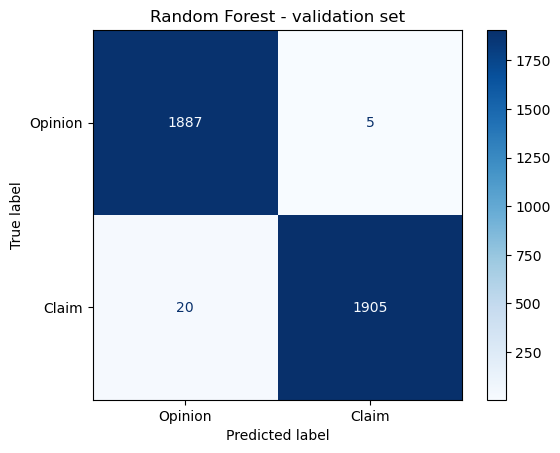

In [35]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix using ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Opinion', 'Claim'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Display plot
plt.title('Random Forest - validation set')
plt.show()


Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.
<br> </br>

**Note:** In other labs there was a custom-written function to extract the accuracy, precision, recall, and F<sub>1</sub> scores from the GridSearchCV report and display them in a table. You can also use scikit-learn's built-in [`classification_report()`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) function to obtain a similar table of results.

In [36]:
# Create a classification report
# Create classification report for random forest model
target_names = ['Opinion', 'Claim']
print(classification_report(y_val, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     Opinion       0.99      1.00      0.99      1892
       Claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** What does your classification report show? What does the confusion matrix indicate?

The model is damn near perfect. Only 25 mis-classifications.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [37]:
# Use the best estimator to predict on the validation data
y_pred = xgb_cv.best_estimator_.predict(X_val)


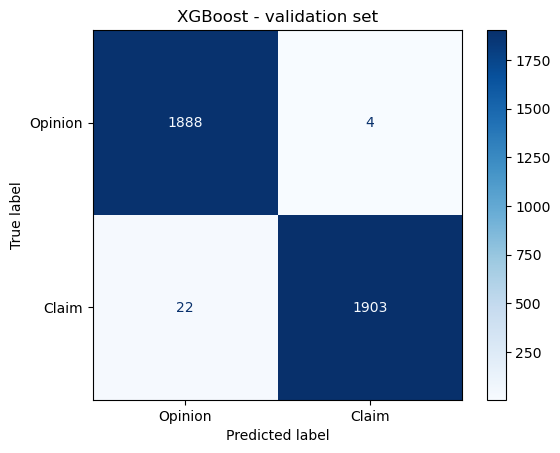

In [38]:
# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix using ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Opinion', 'Claim'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Display plot
plt.title('XGBoost - validation set')
plt.show()


In [39]:
# Create a classification report
target_names = ['Opinion', 'Claim']
print(classification_report(y_val, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     Opinion       0.99      1.00      0.99      1892
       Claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?

### **Use champion model to predict on test data**

In [40]:
### YOUR CODE HERE ###
y_pred = rf_cv.best_estimator_.predict(X_test)

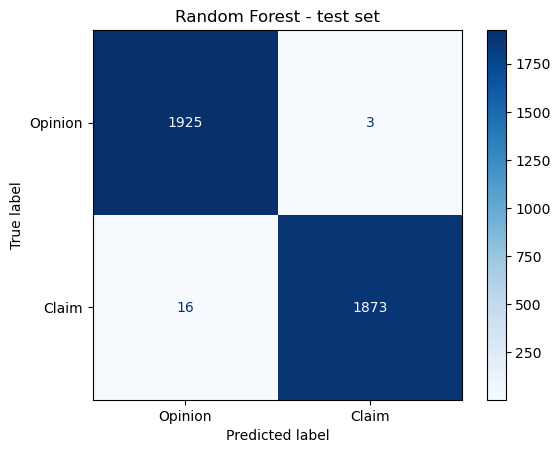

In [41]:
# Compute values for confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix using ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Opinion', 'Claim'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Display plot
plt.title('Random Forest - test set')
plt.show()


In [42]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1928
       claim       1.00      0.99      0.99      1889

    accuracy                           1.00      3817
   macro avg       1.00      0.99      1.00      3817
weighted avg       1.00      1.00      1.00      3817



#### **Feature importances of champion model**


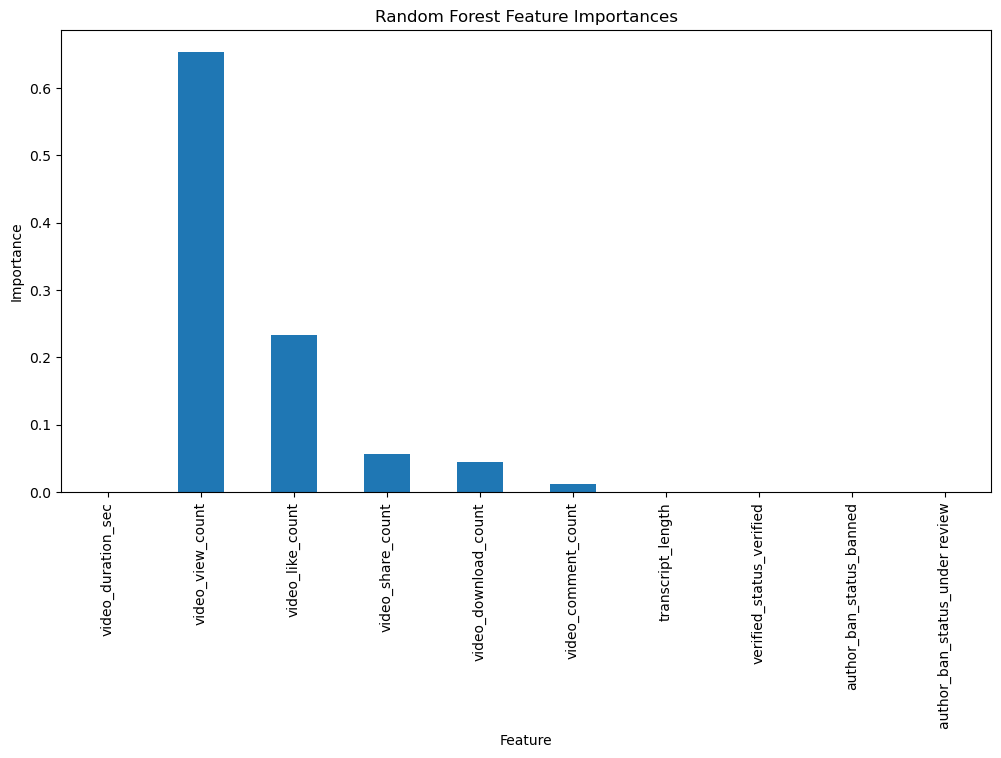

In [43]:
### YOUR CODE HERE ###
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.DataFrame(importances, index=X_test.columns)

rf_importances.plot.bar(figsize=(12, 6), legend=False)
plt.title('Random Forest Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

**Question:** Describe your most predictive features. Were your results surprising?

Engagement metrics were the most predictive features, as expected, based upon earlier EDA.

### **Task 8. Conclusion**

In this step use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**

2. **What was your model doing? Can you explain how it was making predictions?**

3. **Are there new features that you can engineer that might improve model performance?**

4. **What features would you want to have that would likely improve the performance of your model?**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


==> ENTER YOUR RESPONSES HERE

1. Yes, the model has consistently done well on validation and test data.

2. It predicted based on engagement metrics (see feature importance plot).

3. I can't think of any, especially since the model performs damn near perfectly.

4. It'd be nice to know how many times the video has been reported for violating TikTok's terms of service.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.